In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models

C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = os.getcwd() + '\\cifar-10-batches-py\\test_batch'
    else:
        name = os.getcwd() + '\\cifar-10-batches-py\\data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [4]:
rotations_num = 4
saved_name = 'selfsupervised'
selfsupervised_epochs = 20
selfsupervised_batch_size = 32
supervised_epochs = 20
supervised_batch_size = 32
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

In [5]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)
true_labels = np.zeros((60000, 10), dtype = np.float32)

In [6]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    for j in range(data_len):
        row = files[i][b"data"][j]
        for k in range(files[i][b"data"].shape[1]):
            combined_data[data_len * i + j][(k & 1023) >> 5][k & 31][k >> 10] = row[k] / 255.
        true_labels[data_len * i + j][files[i][b"labels"][j]] = 1.
        combined_labels[data_len * i + j] = 0
        for t in range(1, 4):
            combined_data[60000 * t + data_len * i + j] = np.rot90(combined_data[data_len * i + j], t)
            combined_labels[60000 * t + data_len * i + j][t] = 1.

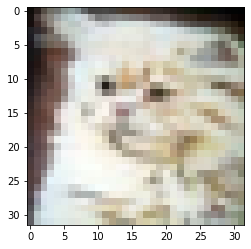

In [14]:
plt.imshow(combined_data[random.randint(0, 49999)])
plt.show()

In [8]:
print(combined_labels[99009])

[0. 1. 0. 0.]


In [9]:
def plot_training(**kwargs):
    for k, v in kwargs.items():
        if k != 'name':
            plt.plot(v, label=k)
    plt.grid(True)
    plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [10]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(rotations_num, activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [11]:
def train_feat():
    model = get_feat_model()
    model.summary()
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, shuffle = True)
    model.save(saved_name)
    return log

In [12]:
log = train_feat()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_v

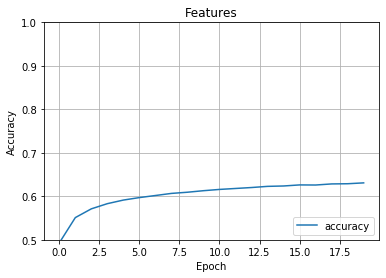

In [15]:
plot_training(accuracy = log.history['acc'], name = 'Features')

In [16]:
def get_cls_model():
    model = tf.keras.models.load_model(saved_name)
    x = model.get_layer('dense').output
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(10, activation = 'softmax')(x)
    return tf.keras.Model(inputs = model.input, outputs = x)

In [17]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
    cls_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [18]:
cls_train_features = train_cls(True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [19]:
cls_no_train_features = train_cls(False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
__________

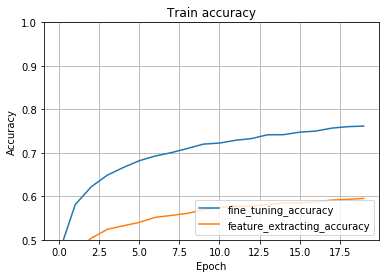

In [20]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['acc'],
              feature_extracting_accuracy = cls_no_train_features.history['acc'])

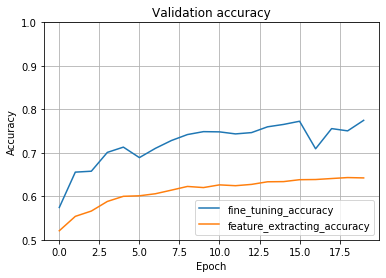

In [21]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_acc'],
              feature_extracting_accuracy = cls_no_train_features.history['val_acc'])